In [14]:
import xarray as xr
from dask.distributed import Client
from dask_ml.cluster import KMeans
# import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [15]:
client = Client()
client

/home/dyllanjr/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37031 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:36901 Dashboard: http://127.0.0.1:37031/status,Cluster Workers: 4 Cores: 12 Memory: 50.56 GB


In [33]:
ds = xr.open_dataset('era5_79_20_decades.nc')

In [34]:
ds

<xarray.Dataset>
Dimensions:          (expver: 2, latitude: 129, longitude: 173, time: 6)
Coordinates:
  * expver           (expver) int32 1 5
  * longitude        (longitude) float32 -18.5 -18.25 -18.0 ... 24.0 24.25 24.5
  * latitude         (latitude) float32 23.5 23.25 23.0 ... -8.0 -8.25 -8.5
  * time             (time) int64 1970 1980 1990 2000 2010 2020
Data variables:
    annual_max_t2m   (time, expver, latitude, longitude) float32 ...
    annual_max_tp    (time, expver, latitude, longitude) float32 ...
    annual_mean_t2m  (time, expver, latitude, longitude) float32 ...
    annual_mean_tp   (time, expver, latitude, longitude) float32 ...
    annual_min_t2m   (time, expver, latitude, longitude) float32 ...
    annual_min_tp    (time, expver, latitude, longitude) float32 ...
    sum_max_t2m      (time, expver, latitude, longitude) float32 ...
    sum_max_tp       (time, expver, latitude, longitude) float32 ...
    sum_mean_t2m     (time, expver, latitude, longitude) float32 ...
    sum_mean_tp      (time, expver, latitude, longitude) float32 ...
    sum_min_t2m      (time, expver, latitude, longitude) float32 ...
    sum_min_tp       (time, expver, latitude, longitude) float32 ...
    win_max_t2m      (time, expver, latitude, longitude) float32 ...
    win_max_tp       (time, expver, latitude, longitude) float32 ...
    win_mean_t2m     (time, expver, latitude, longitude) float32 ...
    win_mean_tp      (time, expver, latitude, longitude) float32 ...
    win_min_t2m      (time, expver, latitude, longitude) float32 ...
    win_min_tp       (time, expver, latitude, longitude) float32 ...

In [35]:
df = ds.to_dask_dataframe()
df = df[df.expver == 1]
t2m_cols = ['annual_max_t2m', 'annual_mean_t2m', 'annual_min_t2m', 'sum_max_t2m', 'sum_mean_t2m', 'sum_min_t2m','win_max_t2m', 'win_mean_t2m', 'win_min_t2m']
(df['win_max_t2m'] > 0).any().compute()

True

In [36]:
#convert to celcius fronm kelvin
for col in t2m_cols:
    df[col] = df[col] - 273.15

In [37]:
#dropping 1970s decade
df = df[df.time != 1970]

In [38]:
df.tail(6)

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
133895,1,-8.5,24.25,2020,23.912628,0.009031,22.802185,0.005412,22.082153,1.862645e-09,...,22.324615,0.007545,22.082153,0.006054,23.912628,0.009031,23.279724,0.003278,22.638214,1.862645e-09
133897,1,-8.5,24.50,1980,24.317108,0.008935,22.352936,0.004163,20.861176,2.837367e-06,...,21.543182,0.007162,20.861176,0.005678,24.317108,0.004124,23.162689,0.001163,22.179596,2.837367e-06
133898,1,-8.5,24.50,1990,24.488983,0.008637,22.614594,0.004015,21.271942,1.784414e-06,...,21.760040,0.006893,21.271942,0.005162,24.488983,0.003792,23.469116,0.001137,22.415009,1.784414e-06
133899,1,-8.5,24.50,2000,24.983856,0.007993,22.805908,0.003630,21.241455,7.779524e-06,...,21.919067,0.006311,21.241455,0.004388,24.983856,0.003329,23.692719,0.000949,22.415009,7.779524e-06
133900,1,-8.5,24.50,2010,24.995270,0.008565,23.076813,0.003510,21.564911,1.862645e-09,...,22.277649,0.006122,21.564911,0.003943,24.995270,0.003661,23.875946,0.000898,22.589539,1.862645e-09
133901,1,-8.5,24.50,2020,23.836334,0.009094,22.714874,0.005322,21.949432,1.862645e-09,...,22.213226,0.008084,21.949432,0.006302,23.836334,0.007093,23.216492,0.002560,22.673157,1.862645e-09


In [39]:
df.expver.value_counts().compute()

1    111585
Name: expver, dtype: int64

In [40]:
df[df.expver == 5].head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp


In [41]:
df[df.expver == 1].tail()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
133897,1,-8.5,24.5,1980,24.317108,0.008935,22.352936,0.004163,20.861176,2.837367e-06,...,21.543182,0.007162,20.861176,0.005678,24.317108,0.004124,23.162689,0.001163,22.179596,2.837367e-06
133898,1,-8.5,24.5,1990,24.488983,0.008637,22.614594,0.004015,21.271942,1.784414e-06,...,21.760040,0.006893,21.271942,0.005162,24.488983,0.003792,23.469116,0.001137,22.415009,1.784414e-06
133899,1,-8.5,24.5,2000,24.983856,0.007993,22.805908,0.003630,21.241455,7.779524e-06,...,21.919067,0.006311,21.241455,0.004388,24.983856,0.003329,23.692719,0.000949,22.415009,7.779524e-06
133900,1,-8.5,24.5,2010,24.995270,0.008565,23.076813,0.003510,21.564911,1.862645e-09,...,22.277649,0.006122,21.564911,0.003943,24.995270,0.003661,23.875946,0.000898,22.589539,1.862645e-09
133901,1,-8.5,24.5,2020,23.836334,0.009094,22.714874,0.005322,21.949432,1.862645e-09,...,22.213226,0.008084,21.949432,0.006302,23.836334,0.007093,23.216492,0.002560,22.673157,1.862645e-09


In [42]:
df.time.value_counts().compute()

2020    22317
2010    22317
2000    22317
1990    22317
1980    22317
Name: time, dtype: int64

In [43]:
df[df.time == 2020].isnull().any().compute()

expver             False
latitude           False
longitude          False
time               False
annual_max_t2m     False
annual_max_tp      False
annual_mean_t2m    False
annual_mean_tp     False
annual_min_t2m     False
annual_min_tp      False
sum_max_t2m        False
sum_max_tp         False
sum_mean_t2m       False
sum_mean_tp        False
sum_min_t2m        False
sum_min_tp         False
win_max_t2m        False
win_max_tp         False
win_mean_t2m       False
win_mean_tp        False
win_min_t2m        False
win_min_tp         False
dtype: bool

In [44]:
#I think I need to drop 2020, 
#even though I'd like to keep it, my features need winter months,
#and I'd probably see a bias if I clustered with a partial year

In [45]:
# df = df[df.time != 2020]

In [46]:
X = df.drop(['latitude', 'longitude', 'time', 'expver'], axis=1)
X.head()

,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,sum_max_t2m,sum_max_tp,sum_mean_t2m,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp
1,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,23.121857,0.000149,21.292938,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032
2,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,23.264008,0.000164,21.489868,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020
3,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,23.481049,0.000079,21.622040,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023
4,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,23.449402,0.000268,21.690277,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011
5,22.417419,0.000080,20.038818,0.000027,18.699524,0.000004,22.417419,0.000080,21.197632,0.000039,20.050201,0.000007,19.227112,0.000022,18.880035,0.000016,18.699524,0.000004


In [47]:
X.isnull().any().compute()

annual_max_t2m     False
annual_max_tp      False
annual_mean_t2m    False
annual_mean_tp     False
annual_min_t2m     False
annual_min_tp      False
sum_max_t2m        False
sum_max_tp         False
sum_mean_t2m       False
sum_mean_tp        False
sum_min_t2m        False
sum_min_tp         False
win_max_t2m        False
win_max_tp         False
win_mean_t2m       False
win_mean_tp        False
win_min_t2m        False
win_min_tp         False
dtype: bool

In [48]:
#using elbow method to find optimal clusters:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df)
    distortions.append(km.inertia_)

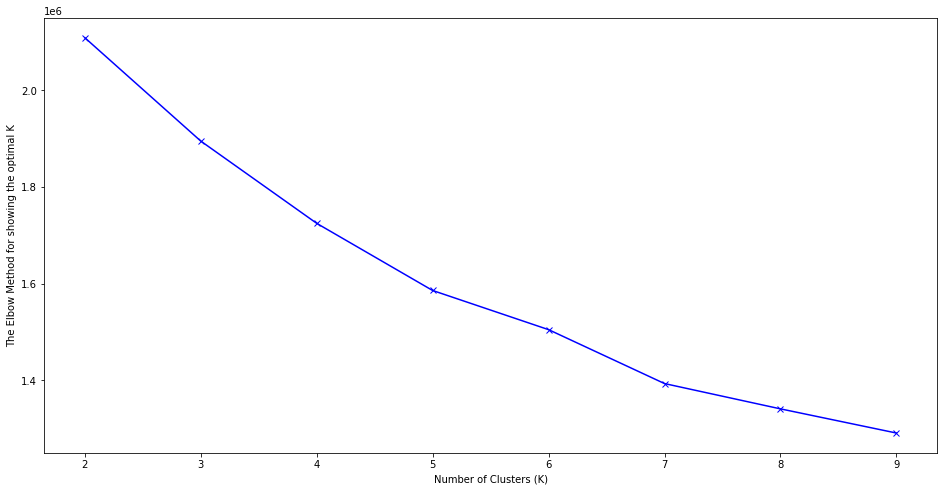

In [49]:
#plotting distortions
plt.figure(figsize=(16, 8))
plt.plot(K[1:], distortions[1:], 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('The Elbow Method for showing the optimal K')
plt.show()

In [52]:
#let's tak ea look at 5 major zones
km = KMeans(n_clusters = 10)
km.fit(X)
labels = km.predict(X)
labels
df['clust'] = labels
clusters = df.groupby('clust')


In [55]:
df.head()

,expver,latitude,longitude,time,annual_max_t2m,annual_max_tp,annual_mean_t2m,annual_mean_tp,annual_min_t2m,annual_min_tp,...,sum_mean_tp,sum_min_t2m,sum_min_tp,win_max_t2m,win_max_tp,win_mean_t2m,win_mean_tp,win_min_t2m,win_min_tp,clust
1,1,23.5,-18.5,1980,23.121857,0.000457,20.658691,0.000104,18.350739,0.000006,...,0.000044,19.254974,0.000006,22.580536,0.000457,20.024475,0.000164,18.350739,0.000032,6
2,1,23.5,-18.5,1990,23.264008,0.000624,20.920990,0.000110,18.687561,0.000005,...,0.000042,19.335541,0.000006,22.744293,0.000623,20.352234,0.000178,18.687561,0.000020,6
3,1,23.5,-18.5,2000,23.561035,0.000780,21.006836,0.000113,18.695404,0.000007,...,0.000030,19.551086,0.000007,23.065369,0.000780,20.391693,0.000196,18.695404,0.000023,6
4,1,23.5,-18.5,2010,23.568298,0.000638,21.051727,0.000108,18.530212,0.000006,...,0.000069,19.525848,0.000007,23.337036,0.000509,20.413147,0.000146,18.530212,0.000011,6
5,1,23.5,-18.5,2020,22.417419,0.000080,20.038818,0.000027,18.699524,0.000004,...,0.000039,20.050201,0.000007,19.227112,0.000022,18.880035,0.000016,18.699524,0.000004,6


<ipython-input-111-f836dada838f>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-111-f836dada838f>:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries()


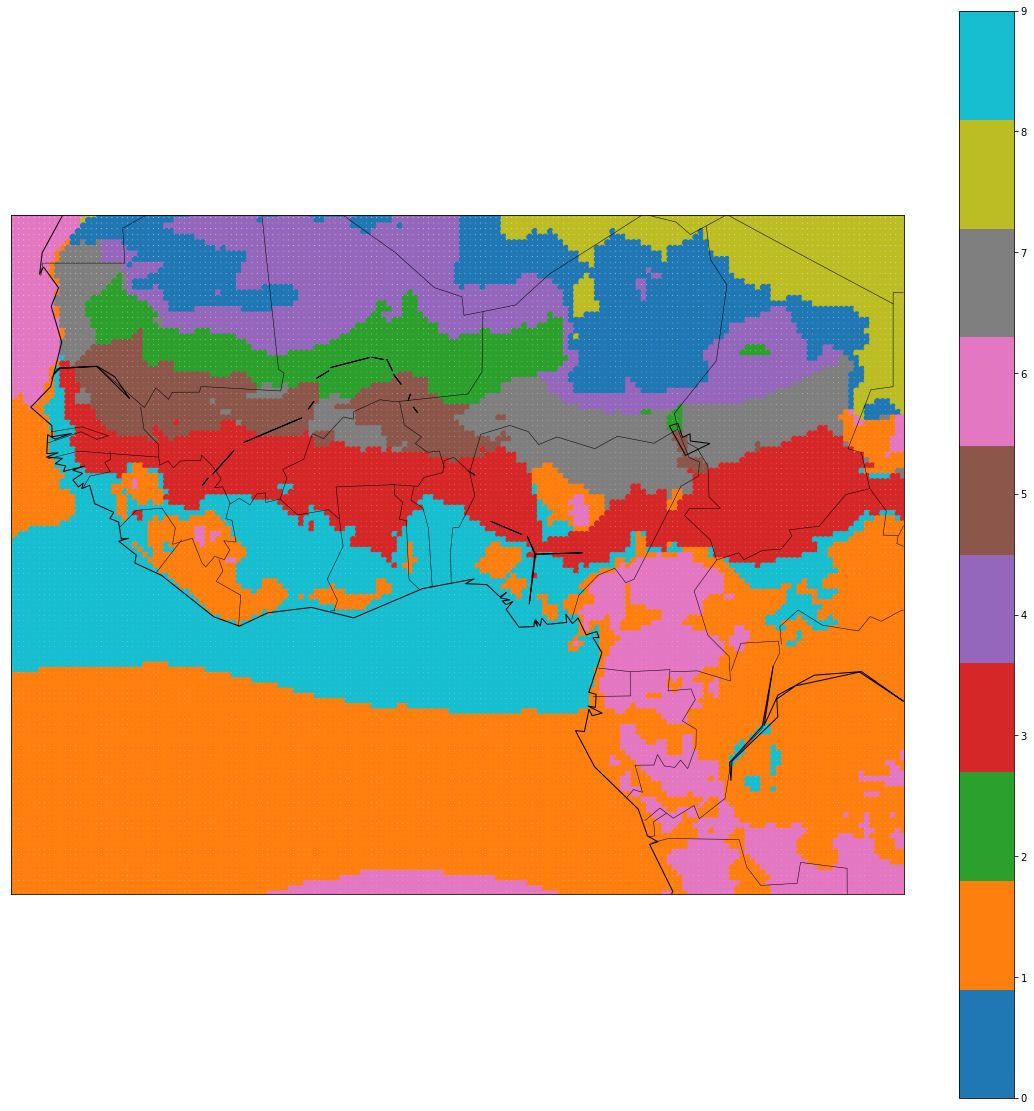

In [111]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
year = df[df.time == 1980]
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
lons = year.longitude.to_dask_array(lengths=True).compute()
lats = year.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=year.clust, cmap='tab10')
m.drawcountries()
m.drawcoastlines()

plt.colorbar()
plt.show()

<ipython-input-110-c35ff74f6ee5>:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)
<ipython-input-110-c35ff74f6ee5>:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1, zorder=2)


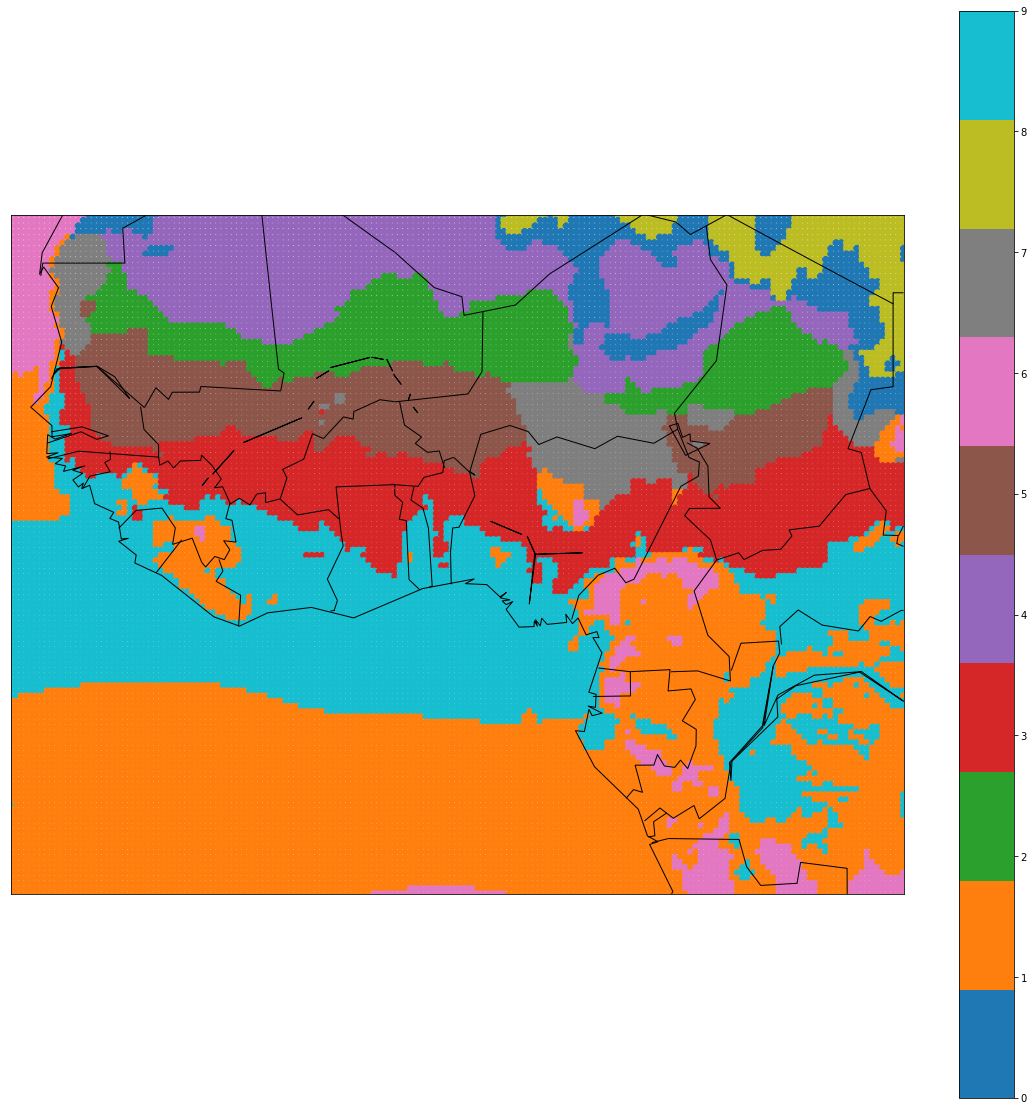

In [110]:
plt.figure(figsize=(20,20))
# ll_lon, ur_lon, ll_lat, ur_lat 
m = Basemap(projection='merc', lon_0=0, llcrnrlat=-8.5, urcrnrlat=23.5, llcrnrlon=-18.5, urcrnrlon = 24.5)

year = df[df.time == 2010]

lons = year.longitude.to_dask_array(lengths=True).compute()
lats = year.latitude.to_dask_array(lengths=True).compute()
x, y = m(lons, lats) #transform coords
plt.scatter(x, y, c=year.clust, cmap='tab10', zorder=1)
m.drawcountries(linewidth=1, zorder=2)
m.drawcoastlines()

plt.colorbar()
plt.show()

In [80]:
means = df.groupby('clust').mean()

In [92]:
means.sum_max_tp.compute()

clust
0    0.000349
1    0.005813
2    0.000777
3    0.007552
4    0.000299
5    0.003255
6    0.006336
7    0.003696
8    0.000198
9    0.008608
Name: sum_max_tp, dtype: float64

In [94]:
means.sum_mean_t2m.compute()

clust
0    31.059257
1    25.097398
2    33.636384
3    28.202116
4    32.944116
5    32.277379
6    22.810891
7    30.236463
8    28.649439
9    26.292329
Name: sum_mean_t2m, dtype: float64

In [116]:
means.sum_mean_tp.compute()

clust
0    0.000094
1    0.003511
2    0.000244
3    0.004015
4    0.000084
5    0.001246
6    0.004653
7    0.001413
8    0.000051
9    0.005147
Name: sum_mean_tp, dtype: float64

In [ ]:
#6-1 cluster movement shows drought and heating effects
#9-1 cluster moverment shows drought effects
#5 is the 3rd highest heat region and is growing
#I could take pairwise differences of variables of each of the clusters, then order the cluster movement by increasing severity,
#then I'll have a map of areas with low, medium, and high risk of each type of cluster movement

In [114]:
clusters = df[df.time == 1980].groupby('clust')
clusters.clust.value_counts().compute() #this gives a relative size of each cluster!

clust  clust
0      0        1541
1      1        7774
2      2         898
3      3        2092
4      4        1610
5      5         817
6      6        1840
7      7        1185
8      8         971
9      9        3589
Name: clust, dtype: int64

In [115]:
clusters = df[df.time == 2010].groupby('clust')
clusters.clust.value_counts().compute() #this gives a relative size of each cluster!

clust  clust
0      0         790
1      1        7154
2      2        1465
3      3        2330
4      4        2039
5      5        1644
6      6         815
7      7         764
8      8         517
9      9        4799
Name: clust, dtype: int64